# Example for the reference resistance calculation

In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# from harps import salinity_harps as sh
from mpim_icelab.harps import salinity_harps as sh


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### Read in data from file

In [11]:
data = sh.read_harp('PycharmProjects/mpim-icelab/tests/test_harps/salinity_harps_test_data.dat')
data

<xarray.Dataset>
Dimensions:      (module: 2, time: 4999, wire_pair: 8)
Coordinates:
  * time         (time) datetime64[ns] 2018-12-23T11:41:11 ... 2019-01-02T14:...
  * module       (module) int64 0 1
  * wire_pair    (wire_pair) int64 0 1 2 3 4 5 6 7
Data variables:
    r16          (time, module, wire_pair) float64 4.741 4.783 4.656 ... nan nan
    r2           (time, module, wire_pair) float64 7.886 7.885 7.824 ... nan nan
    temperature  (time, module, wire_pair) float64 0.5 1.375 1.312 ... nan nan

### Calculate sea-ice properties

In [15]:
data = data.seaice.calc_ice_properties()
data


<xarray.Dataset>
Dimensions:          (module: 2, time: 4999, wire_pair: 8)
Coordinates:
  * time             (time) datetime64[ns] 2018-12-23T11:41:11 ... 2019-01-02...
  * module           (module) int64 0 1
  * wire_pair        (wire_pair) int64 0 1 2 3 4 5 6 7
Data variables:
    r16              (time, module, wire_pair) float64 4.741 4.783 ... nan nan
    r2               (time, module, wire_pair) float64 7.886 7.885 ... nan nan
    temperature      (time, module, wire_pair) float64 0.5 1.375 ... nan nan
    brine_salinity   (time, module, wire_pair) float64 nan nan nan ... nan nan
    bulk_salinity    (module, wire_pair, time) float64 nan nan nan ... nan nan
    solid_fraction   (module, wire_pair, time) float64 nan nan ... 0.007627 nan
    liquid_fraction  (module, wire_pair, time) float64 nan nan ... 0.9924 nan

#### Plot computed properties

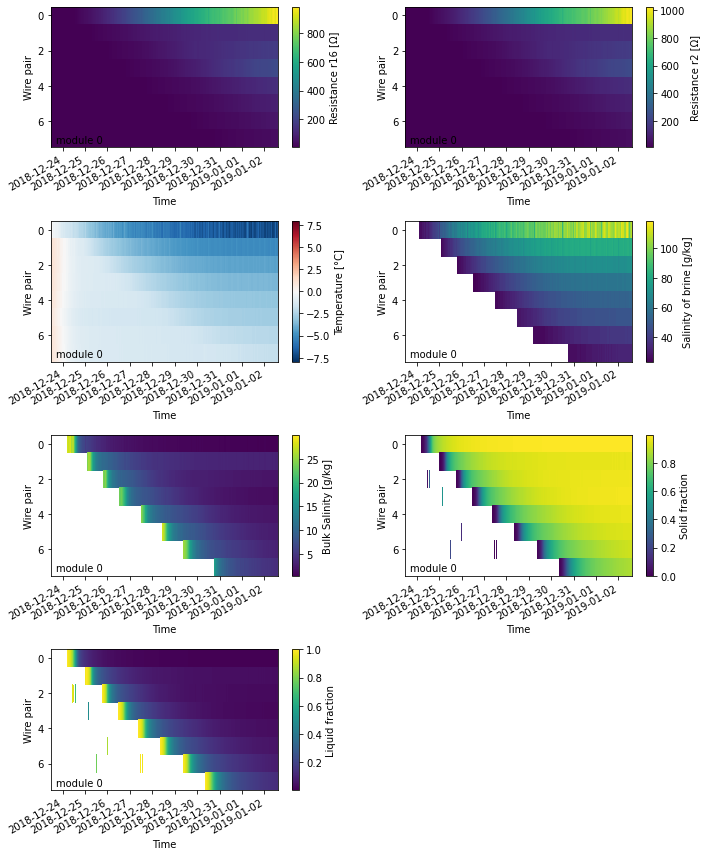

In [14]:
plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(4,2)

data_ = data.sel(module=0)
for i, var in enumerate(data.data_vars):
    ax = plt.subplot(gs[i])
    data_[var].plot(x='time', yincrease=False, ax=ax)
    ax.set_title('')
    ax.text(.02, .03, f"module {data_.module.values}", transform=ax.transAxes)
    # ax.set_xticklabels([])
plt.tight_layout()

### Plot resistance and freezing onsets

In [81]:
colors = sns.color_palette("muted", 8)
r_smooth = sh.median(data['r16'])
r_grad = sh.median(sh.grad(r_smooth, 20))

/home/mpim/m300660/miniconda3/envs/co2/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


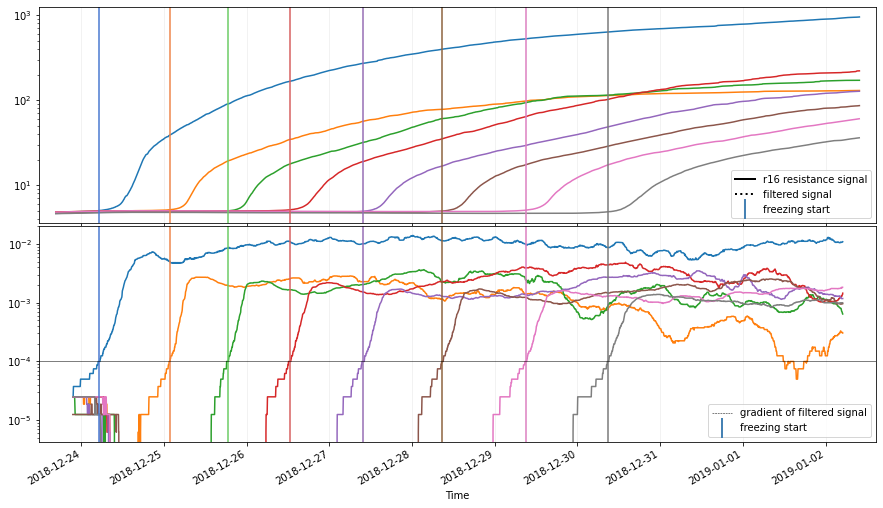

In [86]:
plt.figure(figsize=(15,8))
ax0 = plt.subplot(211)
ax1 = plt.subplot(212)

r_smooth.sel(module=0).plot(hue='wire_pair', ax=ax0)
ax0.set_yscale('log')

r_grad.sel(module=0).plot(hue='wire_pair', ax=ax1)
ax1.set_yscale('log')

for i, date in enumerate(sh.calc_freezing_starts(data).sel(module=0)):
    ax0.axvline(x=date.values, color=colors[i])
    ax1.axvline(x=date.values, color=colors[i])



from matplotlib.lines import Line2D

ax0_legend_elements = [Line2D([0], [0], color='k', lw=2, label='r16 resistance signal'),
                       Line2D([0], [0], color='k', ls=':', lw=2, label='filtered signal'),
                       Line2D([0], [0], color='steelblue', ls='', lw=1, marker='|', markersize=20, mew=2, label='freezing start'),
                       ]

ax1_legend_elements = [Line2D([0], [0], color='k', ls='--', lw=.5, label='gradient of filtered signal'),
                       Line2D([0], [0], color='steelblue', ls='', lw=1, marker='|', markersize=20, mew=2, label='freezing start'),
                       ]
ax1.axhline(1e-4, lw=.5, color='k')

ax0.tick_params(labelbottom=False)
ax0.set_xlabel(None)
plt.subplots_adjust(hspace=0.01)
for axis in plt.gcf().axes:
    axis.grid(axis='x', alpha=.2)
    axis.set_title('')
    # axis.set_xlim(resistance.squeeze().to_pandas().index[0], resistance.squeeze().to_pandas().index[-1])


ax0.legend(handles=ax0_legend_elements, loc='lower right')
ax1.legend(handles=ax1_legend_elements, loc='lower right')

ax0.set_xlim(data.time.values[0], data.time.values[-1])
ax1.set_xlim(data.time.values[0], data.time.values[-1]);